# Matching Exercise 

Luopeiwen Yi

In this exercise, we'll be evaluating how getting a college degree impacts earnings in the US using matching.

## Matching Packages: Python v. R

Just as the best tools for machine learning tend to be in Python since they're developed by CS people (who prefer Python), most of the best tools for causal inference are implemented in R since innovation in causal inference tends to be lead by social scientists using R. As a result, the most well developed matching package is called [MatchIt](https://kosukeimai.github.io/MatchIt/index.html), and is only available in R (though you can always call it from Python using `rpy2`). 

In the last couple years, though, a group of computer scientists and statisticians here at Duke have made some great advancements in matching (especially the computational side of things), and they recently released a set of matching packages in both R and Python that we'll be using today. They have some great algorithms we'll use today, but be aware these packages aren't as mature, and aren't general purpose packages yet. So if you ever get deep into matching, be aware you will probably still want to make at least partial use of the R package [MatchIt](https://kosukeimai.github.io/MatchIt/index.html), as well as some other R packages for new innovative techniques (like [Matching Frontier estimation](https://projects.iq.harvard.edu/frontier/home)), or [Adaptive Hyper-Box Matching](https://almost-matching-exactly.github.io/AHB-R-package/). 

## Installing dame-flame. 

For this lesson, begin by installing `dame-flame` with `pip install dame-flame` (it's not on conda yet). 

[DAME](https://almost-matching-exactly.github.io/DAME-FLAME-Python-Package) is an algorithm that we can use for a version of coarse exact matching. The package only accepts a list of categorical variables, and then attempts to match pairs that match exactly on those variables. That means that if you want to match on, say, age, you have to break it up into categories (say, under 18, 18-29, 30-39, etc. etc.). 

(NOTE: As of 2024, their documentation site is weird: click the dropdowns next to headings to see the content, otherwise the documentation looks deserted)

Of course, one cannot always find exact matches on all variables, so what DAME does is:

1. Find all observations that match on *all* matching variables. 
2. Figure out which matching variable is least useful in predicting the outcome of interest $Y$ and drops that, then tries to match the remaining observations on the narrowed set of matching variables. 
3. This repeats until you run out of variables, all observations are matched, or you hit a stopping run (namely: quality of matches falls below a threshold). 

In addition, the lab has also created FLAME, which does the same thing, but employs some tricks to make it *massively* more computationally efficient, meaning it can be used on datasets with millions of observations (which most matching algorithms cannot). It's a little less accurate, but an amazing contribution never the less. 

## Data Setup

To save you some time and let you focus on matching, I've *pre-cleaned* about one month worth of of data from the US Current Population Survey data we used for our [gender discrimination analysis](exercises/exercises_regression_incomeineq.ipynb). You can download the data [from here](https://github.com/nickeubank/MIDS_Data/blob/master/Current_Population_Survey/cps_for_matching.dta?raw=true"), or read it directly with:

```python 
cps = pd.read_stata(
    "https://github.com/nickeubank/MIDS_Data/blob/master"
    "/Current_Population_Survey/cps_for_matching.dta?raw=true"
)
```

Load the data and quickly familiarize yourself with its contents. 

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

warnings.filterwarnings("ignore")

pd.set_option("mode.copy_on_write", True)

In [2]:
cps = pd.read_stata(
    "https://github.com/nickeubank/MIDS_Data/blob/master"
    "/Current_Population_Survey/cps_for_matching.dta?raw=true"
)

In [3]:
cps.head()

,index,annual_earnings,female,simplified_race,has_college,age,county,class94
0,151404,NaN,1,3.0,1,30,0-WV,"Private, For Profit"
1,123453,NaN,0,0.0,0,21,251-TX,"Private, For Profit"
2,187982,NaN,0,0.0,0,40,5-MA,"Self-Employed, Unincorporated"
3,122356,NaN,1,0.0,1,27,0-TN,"Private, Nonprofit"
4,210750,42900.0,1,0.0,0,52,0-IA,"Private, For Profit"


In [4]:
# Check the shape of the dataset
print(f"Dataset shape: {cps.shape}")

# Check for missing values in each column
missing_values = cps.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Dataset shape: (11150, 8)
Missing values in each column:
index                 0
annual_earnings    5635
female                0
simplified_race       0
has_college           0
age                   0
county                0
class94               0
dtype: int64


In [5]:
# Check distribution of categorical variables:
print("\nDistribution of race:")
print(cps["simplified_race"].value_counts())


Distribution of race:
simplified_race
0.0    7622
2.0    1512
1.0    1020
3.0     996
Name: count, dtype: int64


In [6]:
print("\nDistribution of gender:")
print(cps["female"].value_counts())


Distribution of gender:
female
0    6306
1    4844
Name: count, dtype: int64


In [7]:
print("\nDistribution of college education:")
print(cps["has_college"].value_counts())


Distribution of college education:
has_college
0    6713
1    4437
Name: count, dtype: int64


In [8]:
print("\nDistribution of county:")
print(cps["county"].value_counts())


Distribution of county:
county
0-TX     576
37-CA    275
0-IL     230
0-OH     225
1-DC     223
        ... 
15-MD      1
69-NY      1
81-IN      1
19-IN      1
45-GA      1
Name: count, Length: 326, dtype: int64


In [9]:
print("\nDistribution of class:")
print(cps["class94"].value_counts())


Distribution of class:
class94
Private, For Profit              7809
Government - Local                740
Private, Nonprofit                706
Government - State                615
Self-Employed, Unincorporated     552
Self-Employed, Incorporated       387
Government - Federal              337
Without Pay                         4
Name: count, dtype: int64


## Getting To Know Your Data

Before you start matching, it is important to examine your data to ensure that matching is feasible (you have some overlap the the features of people in the treated and untreated groups), and also that there is a reason *to* match: either you're unsure about some of the functional forms at play, or your have some imbalance between the two groups. 

### Exercise 1

Show the raw difference of `annual_earnings` between those with and without a college degree (`has_college`). Is the difference statistically significant?

In [10]:
# Drop rows where 'annual_earnings' is NaN
cps = cps.dropna(subset=["annual_earnings"])

In [11]:
# Check for missing values in each column
missing_values = cps.isnull().sum()
print("Missing values in each column after dropping NaN:")
print(missing_values)

Missing values in each column after dropping NaN:
index              0
annual_earnings    0
female             0
simplified_race    0
has_college        0
age                0
county             0
class94            0
dtype: int64


In [12]:
# Calculate the mean annual earnings for with and without college degrees
annual_earnings_has_college = cps[cps["has_college"] == 1]["annual_earnings"].mean()
annual_earnings_no_college = cps[cps["has_college"] == 0]["annual_earnings"].mean()

# Calculate the raw difference in mean earnings
raw_difference_annual_earnings = (
    annual_earnings_has_college - annual_earnings_no_college
)

print(f"Raw difference in mean annual earnings: ${raw_difference_annual_earnings:.2f}")

Raw difference in mean annual earnings: $14158.50


In [13]:
# prepare for t-test
with_college = cps[cps["has_college"] == 1]["annual_earnings"]
without_college = cps[cps["has_college"] == 0]["annual_earnings"]
# Perform a t-test to assess if the differences are statistically significant
t_stat, p_value = stats.ttest_ind(with_college, without_college)
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")

T-statistic: 19.24, P-value: 0.0000


> Since P value < 0.05, the difference in earnings between those with and without a college degree is statistically significant.

### Exercise 2

Next we can check for balance. Check the share of people in different racial groups who have college degrees. Are those differences statistically significant? (Remember how to check for difference in distributions of categorical variables).

Race is coded as White Non-Hispanic (0), Black Non-Hispanic (1), Hispanic (2), Other (3).

Does the data seem balanced?

In [14]:
# Calculate the share of people with college degrees within each racial group
college_share_by_race = cps.groupby("simplified_race")["has_college"].mean()

# Mapping race codes to names
race_mapping = {
    0: "White Non-Hispanic",
    1: "Black Non-Hispanic",
    2: "Hispanic",
    3: "Other",
}
# Apply mapping
college_share_by_race.index = college_share_by_race.index.map(race_mapping)

print("Share of people with college degrees by racial group:")
print(college_share_by_race)

Share of people with college degrees by racial group:
simplified_race
White Non-Hispanic    0.230278
Black Non-Hispanic    0.200942
Hispanic              0.117053
Other                 0.255125
Name: has_college, dtype: float64


In [15]:
# Apply mapping to the 'simplified_race' column
cps["simplified_race"] = cps["simplified_race"].map(race_mapping)

# Create a contingency table
contingency_table = pd.crosstab(cps["simplified_race"], cps["has_college"])

print("Contingency Table:")
print(contingency_table)

Contingency Table:
has_college            0    1
simplified_race              
Black Non-Hispanic   509  128
Hispanic             875  116
Other                327  112
White Non-Hispanic  2654  794


In [16]:
# Perform the Chi-Square Test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square Statistic: {chi2:.2f}, P-value: {p_value:.4f}")


Chi-square Statistic: 66.13, P-value: 0.0000


>- Since P value < 0.05, there is a statistically significant difference in the distribution of college degrees across racial groups.
>- The data is not balanced. 

### Exercise 3

One of the other advantages of matching is that even when you have balanced data, you don't have to go through the process of testing out different functional forms to see what fits the data base. 

In our last exercise, we looked at the relationship between gender and earnings "controlling for age", where we just put in age as a linear control. Plot a non-linear regression of `annual_earnings` on age (`PolyFit(order=3)` is fine.)

Does the relationship look linear?

Does this speak to why it's nice to not have to think about functional forms with matching as much?

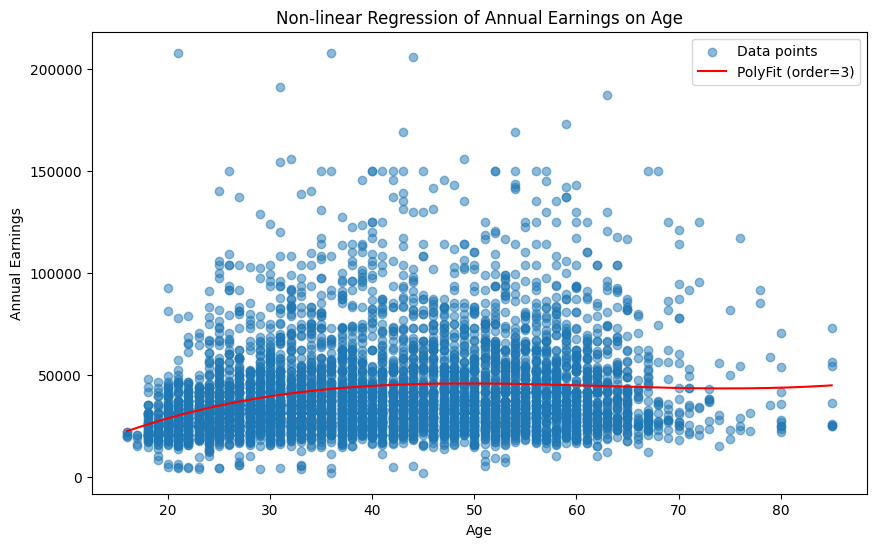

In [17]:
# Fit a polynomial of degree 3 using np.polyfit
x = cps["age"]
y = cps["annual_earnings"]
coefs = np.polyfit(x, y, 3)

# Use np.poly1d to create a polynomial function from the coefficients
p = np.poly1d(coefs)

# Generate a range of ages for plotting the polynomial curve
x_fit = np.linspace(x.min(), x.max(), 500)
y_fit = p(x_fit)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, label="Data points")
plt.plot(x_fit, y_fit, color="red", label="PolyFit (order=3)")
plt.xlabel("Age")
plt.ylabel("Annual Earnings")
plt.title("Non-linear Regression of Annual Earnings on Age")
plt.legend()
plt.show()

>- The relationship doesn't look linear.
>- Matching do not require specifying the exact form of the relationship between the control variables (like age) and the outcome (like earnings). This can reduce the risk of misspecifying the model, which can lead to biased estimates of the effect.

## Matching!

Because DAME is an implementation of exact matching, we have to discretize all of our continuous variables. Thankfully, in this case we only have `age`, so this shouldn't be too hard!

### Exercise 4

Create a new variable that discretizes age into a single value for each decade of age. 

Because CPS only has employment data on people 18 or over, though, include people who are 18 or 19 with the 20 year olds so that group isn't too small, and if you see any other really small groups, please merge those too. 

In [18]:
# Check the data type of 'age' before conversion
print("Data type of 'age' before conversion:", cps["age"].dtype)

# Convert 'age' to a categorical data type
cps["age"] = cps["age"].astype("category")

# Check the data type of 'age' after conversion
print("Data type of 'age' after conversion:", cps["age"].dtype)

Data type of 'age' before conversion: int8
Data type of 'age' after conversion: category


In [19]:
# Check the distribution of each category
age_counts = cps["age"].value_counts().sort_index()
print("Counts of each age group:")
print(age_counts)

Counts of each age group:
age
16     5
17     5
18    45
19    47
20    82
      ..
77     2
78     2
79     2
80    10
85     8
Name: count, Length: 66, dtype: int64


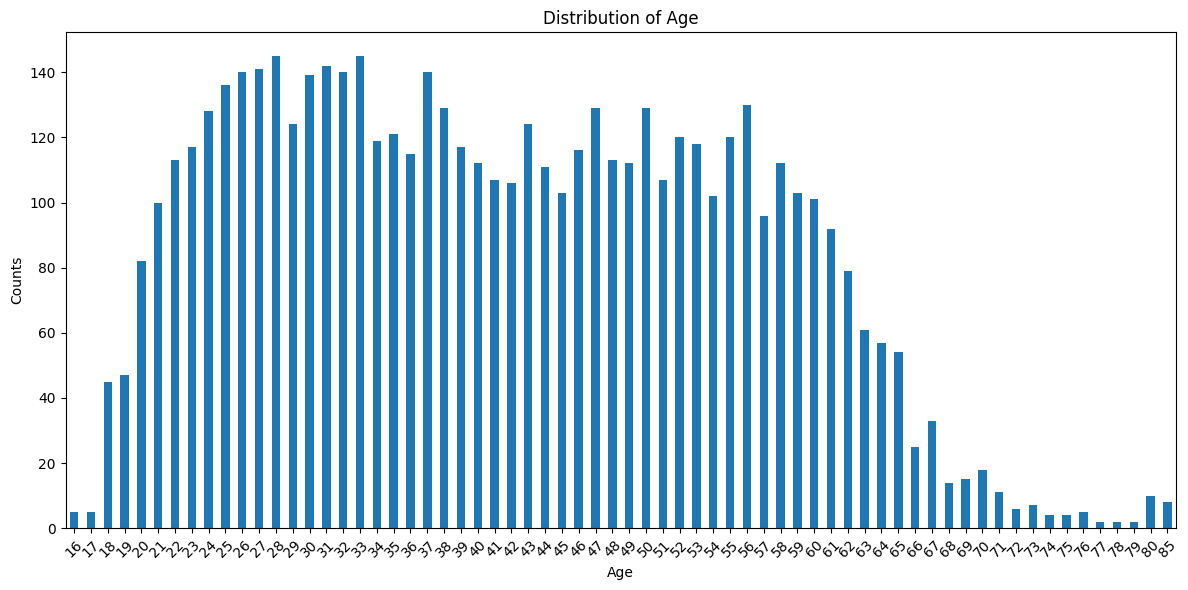

In [20]:
# Plotting the distribution
plt.figure(figsize=(12, 6))
age_counts.plot(kind="bar")
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# Define the bins for age groups
bins = [16, 30, 40, 50, 60, 86]

# Define labels for each bin
labels = [1, 2, 3, 4, 5]

# categorize each age
cps["age_group"] = pd.cut(
    cps["age"], bins=bins, labels=labels, right=False, include_lowest=True
)

# Check the distribution of each category
age_group_counts = cps["age_group"].value_counts().sort_index()
print("Counts of each age group:")
print(age_group_counts)

Counts of each age group:
age_group
1    1328
2    1307
3    1133
4    1137
5     610
Name: count, dtype: int64


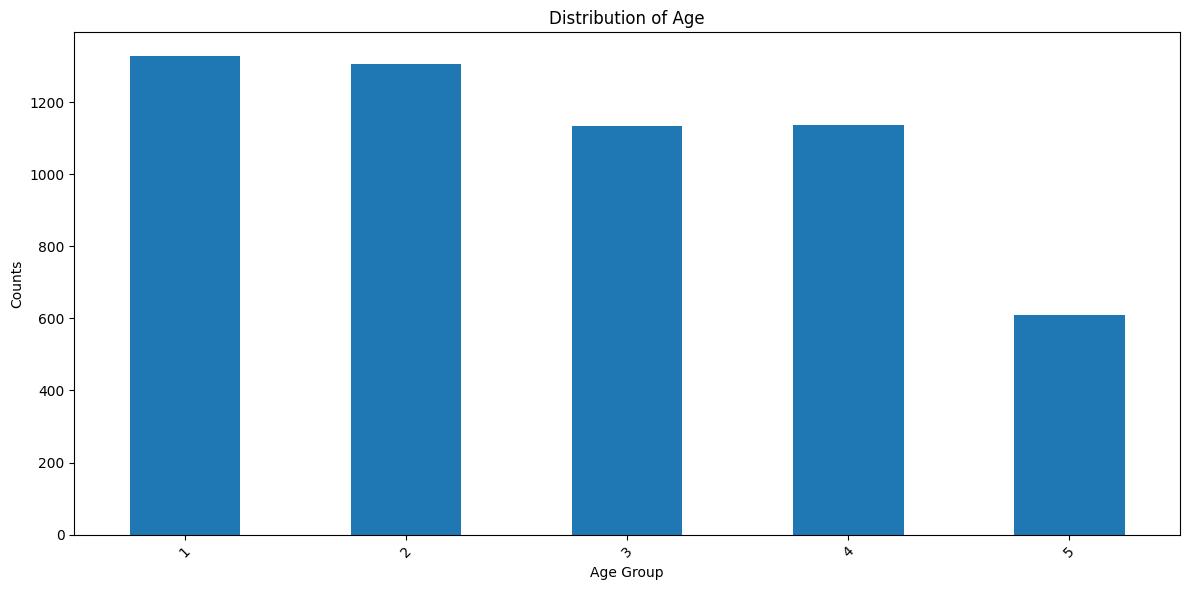

In [22]:
# Plotting the distribution
plt.figure(figsize=(12, 6))
age_group_counts.plot(kind="bar")
plt.title("Distribution of Age")
plt.xlabel("Age Group")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Exercise 5

We also have to covert our string variables into numeric variables for DAME, so convert `county` and `class94` to a numeric vector of intergers. 

(Note: it's not clear whether `class94` belongs: if it reflects people choosing fields based on passion, it belongs; if people choose certain jobs because of their degrees, its not something we'd actually want in our regression. 

Hint: if you use `pd.Categorical` to convert you var to a categorical, you can pull the underlying integer codes with `.codes`. 

In [23]:
# Convert 'county' to a categorical type and extract the codes
cps["county"] = pd.Categorical(cps["county"]).codes

# Convert 'class94' to a categorical type and extract the codes
cps["class94"] = pd.Categorical(cps["class94"]).codes

# Display the first few rows of the 'county' and 'class94' columns
cps[["county", "class94"]].head()

,county,class94
4,10,3
5,31,3
7,8,3
8,44,1
9,24,3


## Let's Do Matching with DAME

### Exercise 6

First, drop all the variables you *don't* want in matching (e.g. your original `age` variable), and any observations for which `annual_earnings` is missing. 

You will probably also have to drop a column named `index`: DAME will try and match on ANY included variables, and so because there was a column called `index` in the data we imported, if we leave it in DAME will try (and obviously fail) to match on index. 

Also, it's best to reset your index, as `dame_flame` using index labels (e.g., the values in `df.index`) to identify matches. So you want to be sure those are unique.

> Already dropped NaN in annual_earnings earlier. 

In [24]:
# Drop the columns age and index
cps = cps.drop(columns=["index", "age"])

# Reset the index of the DataFrame
cps.reset_index(drop=True, inplace=True)

cps.head()

,annual_earnings,female,simplified_race,has_college,county,class94,age_group
0,42900.0,1,White Non-Hispanic,0,10,3,4
1,31200.0,0,Hispanic,0,31,3,2
2,20020.0,0,White Non-Hispanic,1,8,3,5
3,22859.2,0,White Non-Hispanic,0,44,1,3
4,73860.8,0,White Non-Hispanic,1,24,3,2


In [25]:
# Check for missing values in each column
missing_values = cps.isnull().sum()
print("Missing values in each column after dropping NaN:")
print(missing_values)

Missing values in each column after dropping NaN:
annual_earnings    0
female             0
simplified_race    0
has_college        0
county             0
class94            0
age_group          0
dtype: int64


### Exercise 7

The syntax of `dame_flame` is similar to the syntax of `sklearn`. If you start with a dataset called `my_data` with a `treat` variable with treatment assignment and an `outcome` variable for my outcome of interest ($Y$), the syntax to do basic matching would be:

```python
import dame_flame
model = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
)
model.fit(
    for_matching,
    treatment_column_name="has_college",
    outcome_column_name="annual_earnings",
)
result = model.predict(for_matching)
```

Where the arguments:

- `repeats=False` says that I only want each observation to get matched once. We'll talk about what happens if we use `repeats=True` below. 
- `verbose=3` tells dame to report everything it's doing as it goes. 
- `want_pe` says "please include the predictive error in your printout at each step". This is a measure of match quality. 
- `stop_unmatched_t` says "once you've matched all the treatment units, you can stop."

So run DAME on your data!

In [26]:
# Display the data types of each column in the DataFrame
print("Data types of each variable in the DataFrame:")
print(cps.dtypes)

Data types of each variable in the DataFrame:
annual_earnings     float64
female                int32
simplified_race      object
has_college           int32
county                int16
class94                int8
age_group          category
dtype: object


In [27]:
# convert simplified race to code
cps["simplified_race"] = pd.Categorical(cps["simplified_race"]).codes

# convert every columns except outcome to integer type
# cps["annual_earnings"] = cps["annual_earnings"].astype(int)
cps["female"] = cps["female"].astype(int)
cps["has_college"] = cps["has_college"].astype(int)
cps["county"] = cps["county"].astype(int)
cps["class94"] = cps["class94"].astype(int)
cps["simplified_race"] = cps["simplified_race"].astype(int)
cps["age_group"] = cps["age_group"].astype(int)

In [28]:
# Display the data types of each column in the DataFrame
print("Data types of each variable in the DataFrame after converting data types:")
print(cps.dtypes)

Data types of each variable in the DataFrame after converting data types:
annual_earnings    float64
female               int64
simplified_race      int64
has_college          int64
county               int64
class94              int64
age_group            int64
dtype: object


In [29]:
import dame_flame

model = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
)
model.fit(
    cps,
    treatment_column_name="has_college",
    outcome_column_name="annual_earnings",
)
result = model.predict(cps)

Completed iteration 0 of matching
	Number of matched groups formed in total:  376
	Unmatched treated units:  636 out of a total of  1150 treated units
	Unmatched control units:  3174 out of a total of  4365 control units
	Number of matches made this iteration:  1705
	Number of matches made so far:  1705
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  1183757438.590159
Completed iteration 1 of matching
	Number of matched groups formed in total:  498
	Unmatched treated units:  22 out of a total of  1150 treated units
	Unmatched control units:  141 out of a total of  4365 control units
	Number of matches made this iteration:  3647
	Number of matches made so far:  5352
	Covariates dropped so far:  frozenset({'county'})
	Predictive error of covariate set used to match:  1184056768.8683481
Completed iteration 2 of matching
	Number of matched groups formed in total:  498
	Unmatched treated units:  22 out of a total of  1150 treated units
	Unmatched contro

## Interpreting DAME output

The output you get from doing this *should* be reports from about 8 iterations of matching. In each iteration, you'll see a description of the number of matches made in the iteration, the number of treatment units still unmatched, and the number of control units unmatched. 

In the first iteration, the algorithm tries to match observations that match on *all* the variables in your data. That's why in the first iteration, you see the set of variables being dropped is an empty set (`Covariates dropped so far: set()`) — it *hasn't* dropped any variables:

```
Completed iteration 0 of matching
	Number of matched groups formed in total:  370
	Unmatched treated units:  644 out of a total of  1150 treated units
	Unmatched control units:  3187 out of a total of  4365 control units
	Number of matches made this iteration:  1684
	Number of matches made so far:  1684
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  1199312680.0957854

```

(Note depending on how you binned ages, you may get slightly different results than this)

But as we can see from this output, the algorithm found 1,684 perfect matches—pairs of observations (one treated, one untreated) that had *exactly* the same value of all the variables we included. But we also see we still have 644 *unmatched* treated units, so what do we do?


The answer is that if we want to match more of our treatment variables, we have to try and match on a subset of our variables.

But what variable should we drop? This is the secret sauce of DAME. DAME picks the variables to drop by trying to predict our outcome $Y$ using all our variables (by default using a ridge regression), then it drops the matching variable that is contributing the least to that prediction. Since our goal in matching is to eliminate baseline differences ($E(Y_0|D=1) - E(Y_1|D=0)$), dropping the covariates least related to $Y$ makes sense.

As a result, in the second iteration (called iteration 1, since it uses 0-based indexing), we see that the variable it drops first is `county`, and it's subsequently able to make another 3,626 new matches on the remaining variables!

```
Completed iteration 1 of matching
	Number of matched groups formed in total:  494
	Unmatched treated units:  25 out of a total of  1150 treated units
	Unmatched control units:  180 out of a total of  4365 control units
	Number of matches made this iteration:  3626
	Number of matches made so far:  5310
	Covariates dropped so far:  frozenset({'county'})
	Predictive error of covariate set used to match:  1199421883.1095908

```

And so DAME continues until its matched all treated observations, and even then it keeps going to evaluate different covariates it might exclude.

## Exercise 8

Congratulations! You just on your first one-to-many matching! 

The next step is to think about which of the matches that DAME generated are good enough for inclusion in our analysis. As you may recall, one of the choices you have to make as a researcher when doing matching is how "good" a match has to be in order to be included in your final data set. By default, DAME will keep dropping matching variables until it has been able to match all the treated observations or runs out of variables. It will do this no matter how bad the matches start to become -- if it ends up with the treated observation and a control observation that can only be matched on gender, it will match them just on gender, even though we probably don't think that that's a "good" match.

The way to control this behavior is to tell DAME when to stop manually using the `early_stop_iterations` argument to tell the matching algorithm when to stop.

So when is a good time to stop? There's no objective or "right" answer to that question. It fundamentally comes down to a trade-off between bias (which gets higher is you allow more low quality matches into your data) and variance (which will go down as you increase the number of matches you keep).

But one way to start the process of picking a cut point is to examine how the quality of matches evolves over iterations. DAME keeps this information in `model.pe_each_iter`. This shows, for each iteration, the "prediction error" resulting from dropping the variables excluded in each step. This "prediction error" is the difference in the mean-squared error of regressing $Y$ on our matching variables (by default in a ridge regression) with all variables versus with the subset being used for matching in a given iteration. By design, of course, this is always increasing. 

To see how this evolves, plot your `pe` against iteration numbers. You can also see the `pe` values for each iteration reported in the output from when DAME ran above if you want to make your you're lining up the errors with iterations right. 

Are there any points where the match quality seems to fall off dramatically? 

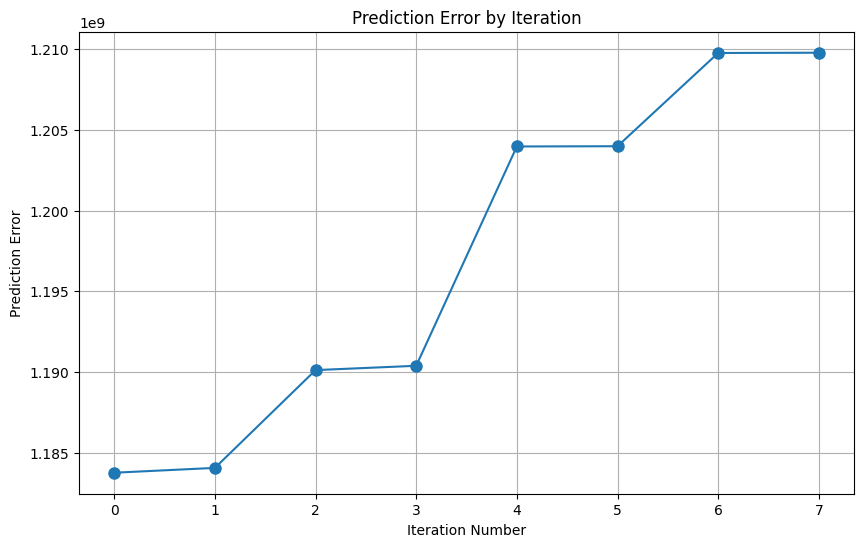

In [30]:
# Retrieve the prediction errors for each iteration
prediction_errors = model.pe_each_iter

# Plotting the prediction errors
plt.figure(figsize=(10, 6))
plt.plot(prediction_errors, marker="o", linestyle="-", markersize=8)
plt.title("Prediction Error by Iteration")
plt.xlabel("Iteration Number")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.show()

> By analyzing the graph, there's a sharp increase in prediction error between iteration 1 and iteration 2, the increase in prediction error spikes between itertation 3 and iteration 4, and there's another sharp increase in prediction error between iteration 5 and iteration 6. The increase in prediction error suggests the match quality seem to fall off dramatically.

### Exercise 9

Suppose we want to ensure we have at least 5,000 observations in our matched data—where might you cut off the data to get a sample size of at least that but before a big quality falloff?

> Since at iteration 1, the sample size in matched data is 5352 (reaching the 5000 observations threshold) without a big increase in prediction error, I will cut off the data at iteration 1 .

### Exercise 10

Re-run your matching, stopping at the point you picked above using `early_stop_iterations`.

In [31]:
model_new = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
    early_stop_iterations=1,  # Stop after iteration 1
)
model_new.fit(
    cps,
    treatment_column_name="has_college",
    outcome_column_name="annual_earnings",
)
result_new = model_new.predict(cps)

Completed iteration 0 of matching
	Number of matched groups formed in total:  376
	Unmatched treated units:  636 out of a total of  1150 treated units
	Unmatched control units:  3174 out of a total of  4365 control units
	Number of matches made this iteration:  1705
	Number of matches made so far:  1705
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  1183757438.590159
Completed iteration 1 of matching
	Number of matched groups formed in total:  498
	Unmatched treated units:  22 out of a total of  1150 treated units
	Unmatched control units:  141 out of a total of  4365 control units
	Number of matches made this iteration:  3647
	Number of matches made so far:  5352
	Covariates dropped so far:  frozenset({'county'})
	Predictive error of covariate set used to match:  1184056768.8683481
5352 units matched. We stopped after iteration 1


## Getting Back a Dataset

OK, my one current complaint with DAME is that it doesn't just give you back a nice dataset of your matches for analysis. If we look at our results — `matches` — it's *almost* what we want, except it has dropped our treatment and outcome columns, and put a string `*` in any entry where a value *wasn't* used for matching:

```
  female simplified_race   county   class94   discretized_age
0  1.0     0.0              10.0      3.0          5.0
1  0.0     2.0              *         3.0          3.0
2  0.0     0.0              8.0        3.0         6.0
3  0.0     0.0              *         1.0          4.0
4  0.0     0.0              24.0      3.0          3.0
```

So for now (though I think this will get updated in the package), we'll have to do it ourselves! Just copy-paste this:

```python

def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better

```



### Exercise 11

Copy-paste that code and run it with your original data, your (fit) model, and what you got back when you ran `result_of_fit`. Then we'll work with the output of that. You should get back a single dataframe of the same length as your original model.

In [32]:
def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    assert len(result_of_fit) == len(better)
    assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better

In [33]:
matched_data = get_dataframe(model_new, result_new)
matched_data.head()

,annual_earnings,female,simplified_race,has_college,county,class94,age_group,match_group,match_group_size,weights
0,42900.0,1,3,0,10,3,4,60.0,5.0,0.936170
1,31200.0,0,1,0,31,3,2,415.0,108.0,0.070654
2,20020.0,0,3,1,8,3,5,53.0,3.0,1.000000
3,22859.2,0,3,0,44,1,3,435.0,28.0,1.248227
4,73860.8,0,3,1,24,3,2,108.0,7.0,1.000000


In [34]:
matched_data.shape

(5352, 10)

## Check Your Matches and Analyze

### Exercise 12

We previously tested balance on `simplified_race` and `county`. Check those again. Are there still statistically significant differences in college education by `simplified_race`?

Note that when you test for this, you'll need to take into account the `weights` column you got back from `get_dataframe`. What DAME does is not actually the 1-to-1 matching described in our readings — instead, however many observations that exact match it finds it puts in the same "group". (These groups are identified in the dataframe you got from `get_dataframe` by the column `match_group`, and the size of each group is in `match_group_size`.)

So to analyze the data, you need to use the `wls` (weighted least squares) function in `statsmodels`. For example, if your data is called `matched_data`, you might run:

```python
smf.wls(
    "has_college ~ C(simplified_race)", matched_data, weights=matched_data["weights"]
).fit().summary()
```

In [35]:
smf.wls(
    "has_college ~ C(simplified_race)", matched_data, weights=matched_data["weights"]
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:            has_college   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                 2.709e-11
Date:                Thu, 02 May 2024   Prob (F-statistic):               1.00
Time:                        13:02:37   Log-Likelihood:                -3764.2
No. Observations:                5352   AIC:                             7536.
Df Residuals:                    5348   BIC:                             7563.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.2108      0.017     12.580      0.000       0.178       0.244
C(simplified_race)[T.1]  1.065e-15      0.024   4.41e-14      1.000      -0.047       0.047
C(simplified_race)[T.2]  9.168e-16      0.025   3.62e-14      1.000      -0.050       0.050
C(simplified_race)[T.3]  8.491e-16      0.018   4.71e-14      1.000      -0.035       0.035
==============================================================================
Omnibus:                      872.095   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1377.393
Skew:                           1.241   Prob(JB):                    8.00e-300
Kurtosis:                       2.871   Cond. No.                         8.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> There are no statistically significant differences in college education by `simplified_race` since P value > 0.05.


### Exercise 13

Now use a weighted least squares regression on your matched data to regress annual earnings on *just* having a college eduction. What is the apparent effect of a BA? How does that compare to our initial estimate using the raw CPS data (before matching)?

In [36]:
model_simple_regression = smf.wls(
    "annual_earnings ~ has_college", matched_data, weights=matched_data["weights"]
).fit()

In [37]:
model_simple_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        annual_earnings   R-squared:                       0.058
Model:                            WLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     327.1
Date:                Thu, 02 May 2024   Prob (F-statistic):           5.26e-71
Time:                        13:02:37   Log-Likelihood:                -62236.
No. Observations:                5352   AIC:                         1.245e+05
Df Residuals:                    5350   BIC:                         1.245e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.914e+04    348.749    112.240      0.000    3.85e+04    3.98e+04
has_college  1.374e+04    759.654     18.085      0.000    1.22e+04    1.52e+04
==============================================================================
Omnibus:                     2955.825   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33660.552
Skew:                           2.419   Prob(JB):                         0.00
Kurtosis:                      14.294   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# To get the coefficient for the 'has_college' variable
college_coefficient = model_simple_regression.params["has_college"]
print(f"Coefficient for 'has_college' without control: {college_coefficient:.2f}")

Coefficient for 'has_college' without control: 13738.36


>- The annual earnings of people who has a college degree is around $13738.36 higher than those without a college degree on average. The difference is statistically significant (p<0.05).
>- Our initial estimate using the raw CPS data (before matching) is that the raw difference in mean annual earnings is around $14158.50 and the difference is statistically significant (p<0.05).
>- The estimated annual earnings difference between people who has a college degree and people without a college degree is smaller in the regression after matching compare to the initial estimate before matching. ($13738.36 < $14158.50)

### Exercise 14

Now include our other matching variables as controls (e.g. all the coefficients you gave to DAME to use). Does the coefficient change?

In [39]:
print(f"Checking the Columns in matched data:")
matched_data.columns

Checking the Columns in matched data:


Index(['annual_earnings', 'female', 'simplified_race', 'has_college', 'county',
       'class94', 'age_group', 'match_group', 'match_group_size', 'weights'],
      dtype='object')

In [40]:
# Model with controls except County
model_with_controls = smf.wls(
    "annual_earnings ~ has_college + female + C(simplified_race) + C(county) + C(class94) + C(age_group)",
    data=matched_data,
    weights=matched_data["weights"],
).fit()

In [41]:
model_with_controls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        annual_earnings   R-squared:                       0.250
Model:                            WLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     5.105
Date:                Thu, 02 May 2024   Prob (F-statistic):          2.03e-147
Time:                        13:02:38   Log-Likelihood:                -61625.
No. Observations:                5352   AIC:                         1.239e+05
Df Residuals:                    5023   BIC:                         1.261e+05
Df Model:                         328                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                5.218e+04   3008.051     17.348      0.000    4.63e+04    5.81e+04
C(simplified_race)[T.1]  2208.0406   1407.418      1.569      0.117    -551.112    4967.193
C(simplified_race)[T.2]  5602.4015   1487.750      3.766      0.000    2685.762    8519.040
C(simplified_race)[T.3]  8390.4204   1054.099      7.960      0.000    6323.925    1.05e+04
C(county)[T.1]          -9077.9080   3214.684     -2.824      0.005   -1.54e+04   -2775.724
C(county)[T.2]          -1.109e+04   3214.450     -3.450      0.001   -1.74e+04   -4786.771
C(county)[T.3]          -7107.0158   1.17e+04     -0.606      0.545   -3.01e+04    1.59e+04
C(county)[T.4]          -5988.3604   2976.338     -2.012      0.044   -1.18e+04    -153.440
C(county)[T.5]          -4905.5562   4101.290     -1.196      0.232   -1.29e+04    3134.762
C(county)[T.6]           -1.45e+04   1.04e+04     -1.400      0.161   -3.48e+04    5797.931
C(county)[T.7]          -8878.0549   3739.540     -2.374      0.018   -1.62e+04   -1546.924
C(county)[T.8]          -1.027e+04   3148.927     -3.260      0.001   -1.64e+04   -4093.283
C(county)[T.9]          -1.313e+04   5070.645     -2.590      0.010   -2.31e+04   -3192.866
C(county)[T.10]         -1.296e+04   3433.164     -3.776      0.000   -1.97e+04   -6232.670
C(county)[T.11]         -1.271e+04   3013.891     -4.217      0.000   -1.86e+04   -6801.842
C(county)[T.12]         -7188.8121   3093.872     -2.324      0.020   -1.33e+04   -1123.472
C(county)[T.13]         -1.215e+04   3335.608     -3.641      0.000   -1.87e+04   -5606.460
C(county)[T.14]         -1.232e+04   3900.820     -3.160      0.002      -2e+04   -4677.631
C(county)[T.15]         -7589.3775   4762.200     -1.594      0.111   -1.69e+04    1746.613
C(county)[T.16]         -9512.1780   3587.567     -2.651      0.008   -1.65e+04   -2478.981
C(county)[T.17]         -1.532e+04   7655.484     -2.002      0.045   -3.03e+04    -315.505
C(county)[T.18]          2671.5885   4860.978      0.550      0.583   -6858.049    1.22e+04
C(county)[T.19]         -1.563e+04   6489.126     -2.409      0.016   -2.84e+04   -2911.564
C(county)[T.20]         -1.092e+04   4150.201     -2.632      0.009   -1.91e+04   -2788.190
C(county)[T.21]         -4855.3397   3567.189     -1.361      0.174   -1.18e+04    2137.907
C(county)[T.22]         -1.653e+04   3636.754     -4.545      0.000   -2.37e+04   -9400.350
C(county)[T.23]          -1.26e+04   3214.497     -3.918      0.000   -1.89e+04   -6293.857
C(county)[T.24]         -1.114e+04   3140.952     -3.548      0.000   -1.73e+04   -4985.399
C(county)[T.25]         -1.489e+04   3445.829     -4.320      0.000   -2.16e+04   -8130.898
C(county)[T.26]         -1.304e+04   3104.834     -4.200      0.000   -1.91e+04   -6953.950
C(county)[T.27]         -1.237e+04   3308.120  

In [42]:
# To get the coefficient for the 'has_college' variable
college_coefficient_control = model_with_controls.params["has_college"]
print(f"Coefficient for 'has_college' with controls: {college_coefficient_control:.2f}")

Coefficient for 'has_college' with controls: 13042.71


>- The coefficient of 'has_college' changes from $13738.36 to $13042.71.
>- The estimated annual earnings difference between people who has a college degree and people without a college degree is smaller in the regression with controls after matching compare to the regression without controls after matching. ($13042.71 < $13738.36)

### Exercise 15

If you stopped matching after the second iteration (Iteration 1) back in Exercise 10, you may be wondering if that was a good choice! Let's check by restricting our attention to ONLY exact matches (`iteration = 0`). Run that match.

In [43]:
model_0 = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
    early_stop_iterations=0,  # Stop after iteration 0
)
model_0.fit(
    cps,
    treatment_column_name="has_college",
    outcome_column_name="annual_earnings",
)
result_0 = model_0.predict(cps)

Completed iteration 0 of matching
	Number of matched groups formed in total:  376
	Unmatched treated units:  636 out of a total of  1150 treated units
	Unmatched control units:  3174 out of a total of  4365 control units
	Number of matches made this iteration:  1705
	Number of matches made so far:  1705
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  1183757438.590159
1705 units matched. We stopped after iteration 0


In [44]:
matched_data_new = get_dataframe(model_0, result_0)
matched_data_new.head()

,annual_earnings,female,simplified_race,has_college,county,class94,age_group,match_group,match_group_size,weights
0,42900.0,1,3,0,10,3,4,60.0,5.0,0.579280
2,20020.0,0,3,1,8,3,5,53.0,3.0,1.000000
4,73860.8,0,3,1,24,3,2,108.0,7.0,1.000000
6,32760.0,1,3,0,90,3,1,280.0,3.0,1.158560
12,27040.0,0,3,0,10,3,1,56.0,8.0,0.331017


In [45]:
matched_data_new.shape

(1705, 10)


### Exercise 16

Now use a weighted linear regression on your matched data to regress annual earnings on *just* having a college eduction. Is that different from what you had when you allowed more low quality matches?

In [46]:
model_regression_new = smf.wls(
    "annual_earnings ~ has_college",
    matched_data_new,
    weights=matched_data_new["weights"],
).fit()

In [47]:
model_regression_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        annual_earnings   R-squared:                       0.052
Model:                            WLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     93.40
Date:                Thu, 02 May 2024   Prob (F-statistic):           1.51e-21
Time:                        13:02:39   Log-Likelihood:                -19761.
No. Observations:                1705   AIC:                         3.953e+04
Df Residuals:                    1703   BIC:                         3.954e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.924e+04    663.350     59.148      0.000    3.79e+04    4.05e+04
has_college  1.168e+04   1208.156      9.665      0.000    9306.737     1.4e+04
==============================================================================
Omnibus:                      850.639   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6368.238
Skew:                           2.222   Prob(JB):                         0.00
Kurtosis:                      11.360   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
# To get the coefficient for the 'has_college' variable
college_coefficient_new = model_regression_new.params["has_college"]
print(
    f"Coefficient for 'has_college' without allowing for more low quality matches: {college_coefficient_new:.2f}"
)

Coefficient for 'has_college' without allowing for more low quality matches: 11676.36


>- Coefficient for 'has_college' after allowing for more low quality matches (stop matching after iteration number 1) is $ 13738.36. 
>- Coefficient for 'has_college' without allowing for more low quality matches (stop matching after the iteration number 0) is around $11676.36. 
>- The estimated annual earnings difference between people who has a college degree and people without a college degree is larger in the regression allowing for more low quality matches than for regression without allowing for more low quality matches.($13738.36 > $11676.36)

## Other Forms of Matching

OK, hopefully this gives you a taste of matching! There are, of course, *many* other permutations to be aware of though. 

- Matching with replacement.  In this exercise, we set `repeat=False`, so each observation could only end up in our final dataset once. However, if we use `repeat=True`, if an untreated observation is the closest observation to multiple treated observations, it may get put in the dataset multiple times. We can still use this dataset in *almost* the same way, though, except we have to make use of weights so that if an observation appears, say, twice, each observation has a weight that's 1/2 the weight of an observation only appearing once. 
- Matching with continuous variables: DAME is used for exact matching, but if you have lots of continuous variables, you can also match on those. In fact, the Almost Exact Matching Lab also has a library called [MALTS](https://almost-matching-exactly.github.io/MALTS/) that will do matching with continuous variables. That package does something *like* Mahalanobis Distance matching, but ulike Mahalanobis, which calculates the distance between observations in terms of the difference in all the matching variables normalized by each matching variable's standard deviation, MALTS does something much more clever. (Here's [the paper](https://arxiv.org/abs/1811.07415) describing the technique if you want all the details). Basically, it figures out how well each matching variable predicts our outcome $Y$, then weights the different variables by their predictive power instead of just normalizing by something arbitrary like their standard deviation. As a result, final matches will prioritize matching more closely on variables that are outcome-relevant. In addition, when it sees a categorical variable, it recognizes that and only pairs observations when they are an exact match on that categorical variable. 
- If you're dataset is huge, use `FLAME`: this dataset is small, but if you have lots of observations and lots of matching variable, the computational complexity of this task explodes, so the AEML created FLAME, which works with millions of observations at only a small cost to match quality. 